In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

In [13]:
#Set global style parameters for all plots
plt.style.use('default')  # More professional than seaborn-whitegrid
sns.set_palette("colorblind")  # Colorblind-friendly palette
plt.rcParams['figure.dpi'] = 300  # High resolution
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.titleweight'] = 'bold'

def plot_winter_nonwinter_median_with_iqr(df):
    """
    Enhanced version of winter vs non-winter median hourly demand plot
    """
    # Calculate statistics
    hourly_stats_median = df.groupby(['hour', 'season_group', 'is_weekend'])['kwh'].agg(
        median='mean',
        q1=lambda x: np.percentile(x, 25),
        q3=lambda x: np.percentile(x, 75)
    ).reset_index()

    # Create figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
    
    # Season labels and colors
    seasons = ['Winter', 'Non-Winter']
    colors = {'Weekday': '#1f77b4', 'Weekend': '#ff7f0e'}
    season_titles = {'Winter': 'December - February', 'Non-Winter': 'March - November'}
    
    for i, season in enumerate(seasons):
        ax = axes[i]
        
        for day_type in ['Weekday', 'Weekend']:
            subset = hourly_stats_median[
                (hourly_stats_median['season_group'] == season) & 
                (hourly_stats_median['is_weekend'] == day_type)
            ].sort_values('hour')
            
            # Plot median line
            ax.plot(subset['hour'], subset['median'], 
                    label=day_type, color=colors[day_type], linewidth=2)
            
            # Add IQR shading
            ax.fill_between(subset['hour'], subset['q1'], subset['q3'], 
                           alpha=0.2, color=colors[day_type],label=f"{day_type} IQR")
        
        # Customize subplot
        ax.set_title(f'{season}: {season_titles[season]}', fontweight='bold')
        ax.set_xlabel('Hour of Day')
        ax.set_xticks(range(0, 24, 3))
        ax.grid(True, alpha=0.3)
        ax.set_xlim(0, 23)
        
        # Add legend to first subplot only
        if i == 1:
            ax.legend(loc='upper right', frameon=True, facecolor='white')
    
    # Set common y-label
    fig.text(0.04, 0.5, 'Average Hourly Energy Consumption (kWh)', 
             va='center', rotation='vertical', fontweight='bold')
    
    # Main title
    plt.suptitle('Hourly Energy Consumption Patterns: Winter vs. Non-Winter Seasons', 
                 fontsize=16, fontweight='bold', y=0.98)
    
    plt.tight_layout(rect=[0.05, 0, 1, 0.96])
    
    # Save with high resolution
    plt.savefig('winter_vs_nonwinter_consumption.png', dpi=300, bbox_inches='tight')
    plt.show()

    
    
def plot_median_kwh_with_temp(df):
    """
    Enhanced version of median daily kWh with temperature
    """
    # Calculate daily statistics
    daily_kwh_per_home = df.groupby(['date', 'meter'])['kwh'].sum().reset_index()
    kwh_stats = daily_kwh_per_home.groupby('date')['kwh'].agg(
        median_kwh='mean',
        iqr=lambda x: x.quantile(0.75) - x.quantile(0.25)
    ).reset_index()
    
    # Get temperature data
    avg_temp_per_day = df.groupby('date')['daily avg temp'].mean().reset_index()
    plot_df = kwh_stats.merge(avg_temp_per_day, on='date', how='left')
    plot_df['date'] = pd.to_datetime(plot_df['date'])
    
    # Create figure
    fig, ax1 = plt.subplots(figsize=(14, 6))
    
    # Plot energy consumption with IQR
    dates = plot_df['date']
    median_kwh = plot_df['median_kwh']
    iqr = plot_df['iqr']
    
    ax1.fill_between(dates, median_kwh - iqr/2, median_kwh + iqr/2, 
                    alpha=0.3, color='steelblue', label='IQR')
    ax1.plot(dates, median_kwh, color='steelblue', linewidth=2, label='Mean Daily Consumption')
    ax1.set_ylabel('Mean Daily Energy Consumption (kWh)', color='steelblue', fontweight='bold')
    ax1.tick_params(axis='y', labelcolor='steelblue')
    ax1.grid(True, alpha=0.3)
    
    # Plot temperature on second axis
    ax2 = ax1.twinx()
    ax2.plot(dates, plot_df['daily avg temp'], color='coral', 
             linestyle='--', linewidth=1.5, label='Average Daily Temperature')
    ax2.set_ylabel('Temperature (°F)', color='coral', fontweight='bold')
    ax2.tick_params(axis='y', labelcolor='coral')
    
    # Format x-axis
    ax1.xaxis.set_major_formatter(DateFormatter('%b %Y'))
    ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
    
    # Title and legend
    plt.title('Daily Energy Consumption vs. Temperature Over Time', 
              fontsize=16, fontweight='bold', pad=20)
    
    # Combine legends from both axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', frameon=True)
    
    plt.tight_layout()
    
    # Save with high resolution
    plt.savefig('consumption_vs_temperature.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    
    
def plot_kwh_vs_temp_poly(df, degree=2):
    """
    Corrected analysis of daily household energy consumption vs temperature.
    
    Parameters:
        df (pd.DataFrame): Input DataFrame with hourly data
        degree (int): Degree of polynomial (default=2)
    """
    # First, calculate daily total consumption for each household
    daily_household_totals = df.groupby(['date', 'meter'])['kwh'].sum().reset_index()
    daily_household_mean = daily_household_totals.groupby('date')['kwh'].mean().reset_index()
    # Then calculate average temperature for each day
    daily_temp = df.groupby('date')['daily avg temp'].mean().reset_index()
    
    # Merge the data
    analysis_df = daily_household_mean.merge(daily_temp, on='date')
    
    # Now we can analyze the relationship
    X = analysis_df[['daily avg temp']]
    y = analysis_df['kwh']  # This is daily total kWh per household
    
    # Continue with polynomial fitting as before
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X)
    
    model = LinearRegression().fit(X_poly, y)
    
    # Generate predictions for plotting
    x_range = np.linspace(X['daily avg temp'].min(), X['daily avg temp'].max(), 200).reshape(-1, 1)
    x_range_poly = poly.transform(x_range)
    y_pred = model.predict(x_range_poly)
    
    # Create the plot
    plt.figure(figsize=(12, 7), dpi=300)
    plt.scatter(X, y, alpha=0.5, s=20, color='steelblue', label='Household-Daily Observations')
    plt.plot(x_range, y_pred, color='crimson', linewidth=3, label=f'Polynomial Fit (Degree {degree})')
    
    # Add labels and title
    plt.xlabel('Average Daily Temperature (°F)', fontweight='bold', fontsize=12)
    plt.ylabel('Daily Energy Consumption per Household (kWh)', fontweight='bold', fontsize=12)
    plt.title('Relationship Between Temperature and Daily Household Energy Consumption', 
              fontweight='bold', fontsize=14, pad=20)
    
    # Calculate and display R²
    r_squared = model.score(X_poly, y)
    plt.text(0.05, 0.95, f'R² = {r_squared:.3f}', transform=plt.gca().transAxes,
             bbox=dict(facecolor='white', alpha=0.8), fontsize=12)
    
    # Find and annotate optimal temperature
    optimal_temp = x_range[np.argmin(y_pred)][0]
    min_consumption = np.min(y_pred)
    plt.annotate(f'Optimal Temperature: {optimal_temp:.1f}°F\nMin Consumption: {min_consumption:.1f} kWh',
                xy=(optimal_temp, min_consumption), xytext=(optimal_temp+10, min_consumption+5),
                arrowprops=dict(arrowstyle='->', color='black'),
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig('corrected_kwh_vs_temp_analysis.png', bbox_inches='tight')
    plt.show()
    
    return {
        "r_squared": r_squared,
        "optimal_temperature": optimal_temp,
        "min_consumption": min_consumption,
        "model_coefficients": model.coef_.tolist(),
        "model_intercept": model.intercept_
    }

In [3]:
def load_and_prepare_data(path, sheet_name="in"):
    """
    Loads and preprocesses the dataset:
    - Reads Excel file
    - Parses datetime
    - Creates datetime-based features
    - Adds weekday/weekend flag
    - Adds winter/non-winter classification
    
    Args:
        path (str): Path to the Excel file
        sheet_name (str): Sheet name (default="in")
    
    Returns:
        pd.DataFrame: Preprocessed dataframe
    """
    # Load Excel file
    df = pd.read_excel(path, sheet_name=sheet_name)

    # Standardize column names (fix spacing)
    #df.rename(columns={
    #    'date time': 'datetime',
    #    'hourly temp': 'hourly_temp',
    #    'daily min temp': 'daily_min_temp',
    #    'daily max  temp': 'daily_max_temp',
    #    'daily avg temp': 'daily_avg_temp',
    #    'kwh': 'kwh'
    #}, inplace=True)

    # Parse datetime
    df['date time'] = pd.to_datetime(df['date time'], errors='coerce')
    df = df.set_index('date time')

    # Create datetime features
    df['date'] = df.index.date
    df['day_of_week'] = df.index.dayofweek          # Monday=0
    df['day_of_month'] = df.index.day
    df['day_of_year'] = df.index.dayofyear
    df['hour'] = df.index.hour
    df['hour_of_week'] = (df.index.dayofweek * 24) + df.index.hour
    df['hour_of_month'] = ((df.index.day - 1) * 24) + df.index.hour
    df['hour_of_year'] = ((df.index.dayofyear - 1) * 24) + df.index.hour
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['week_of_year'] = df.index.isocalendar().week
    df['quarter'] = df.index.quarter

    # Add weekday/weekend classification
    df['is_weekend'] = df.index.dayofweek.map(lambda x: 'Weekend' if x >= 5 else 'Weekday')

    # Add season group (Winter vs Non-Winter)
    def get_season_group(month):
        if month in [12, 1, 2]:
            return 'Winter'
        else:
            return 'Non-Winter'
    df['season_group'] = df['month'].apply(get_season_group)

    return df

In [4]:
path = '/Users/bmuhwezi/OneDrive - University of Massachusetts/Jobs_docs/Tacoma_public_utilities/HomeWorkAssignment-Evaluation&LoadResearchAnalyst/hp_extract.xlsx'
df = load_and_prepare_data(path)

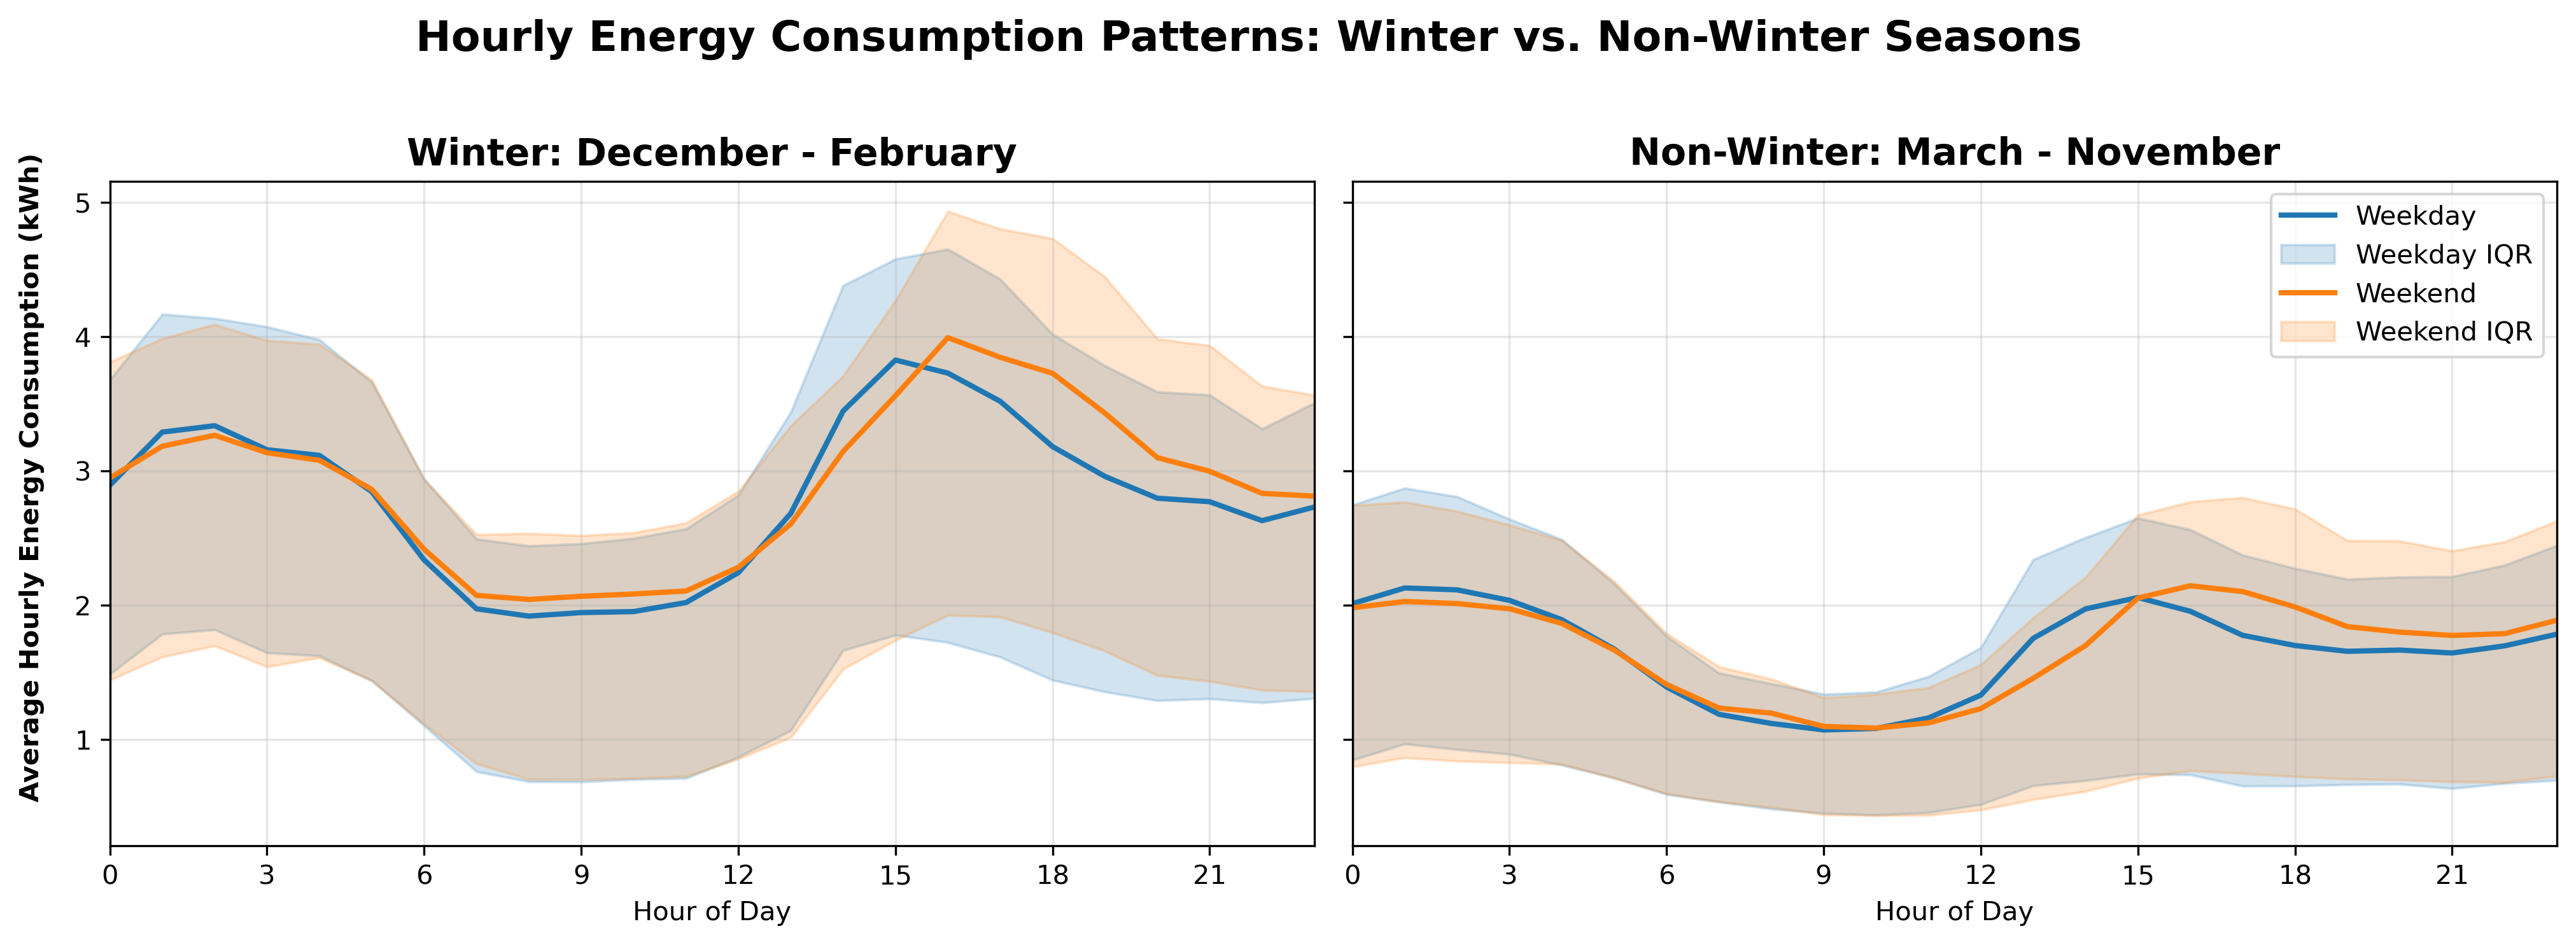

In [5]:
plot_winter_nonwinter_median_with_iqr(df)

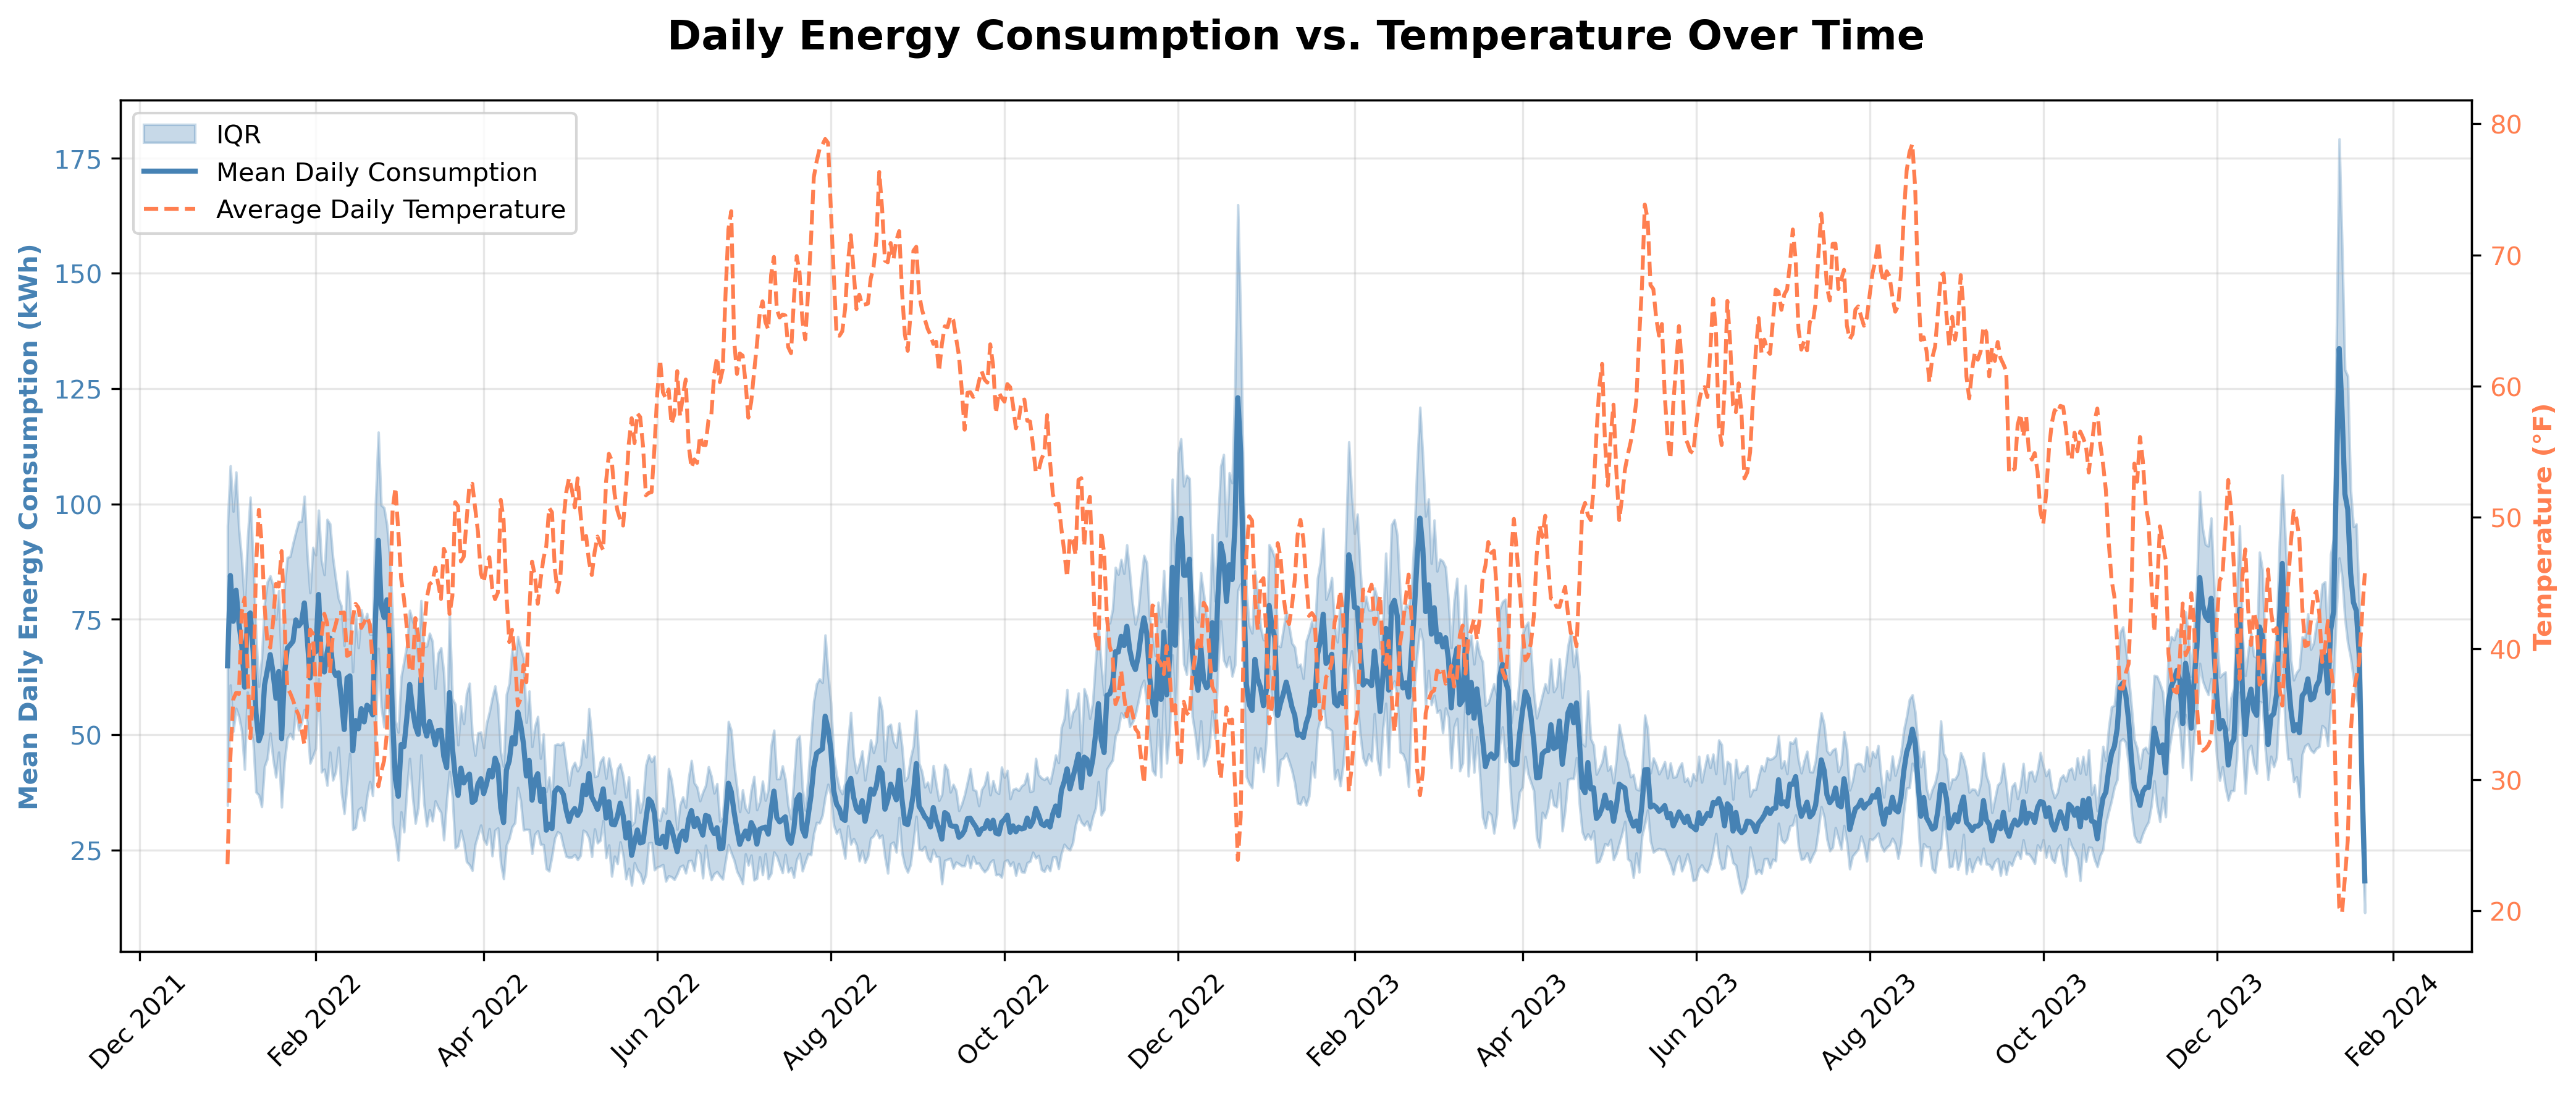

In [6]:
plot_median_kwh_with_temp(df)

/Users/bmuhwezi/anaconda3/envs/butterfly-env/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


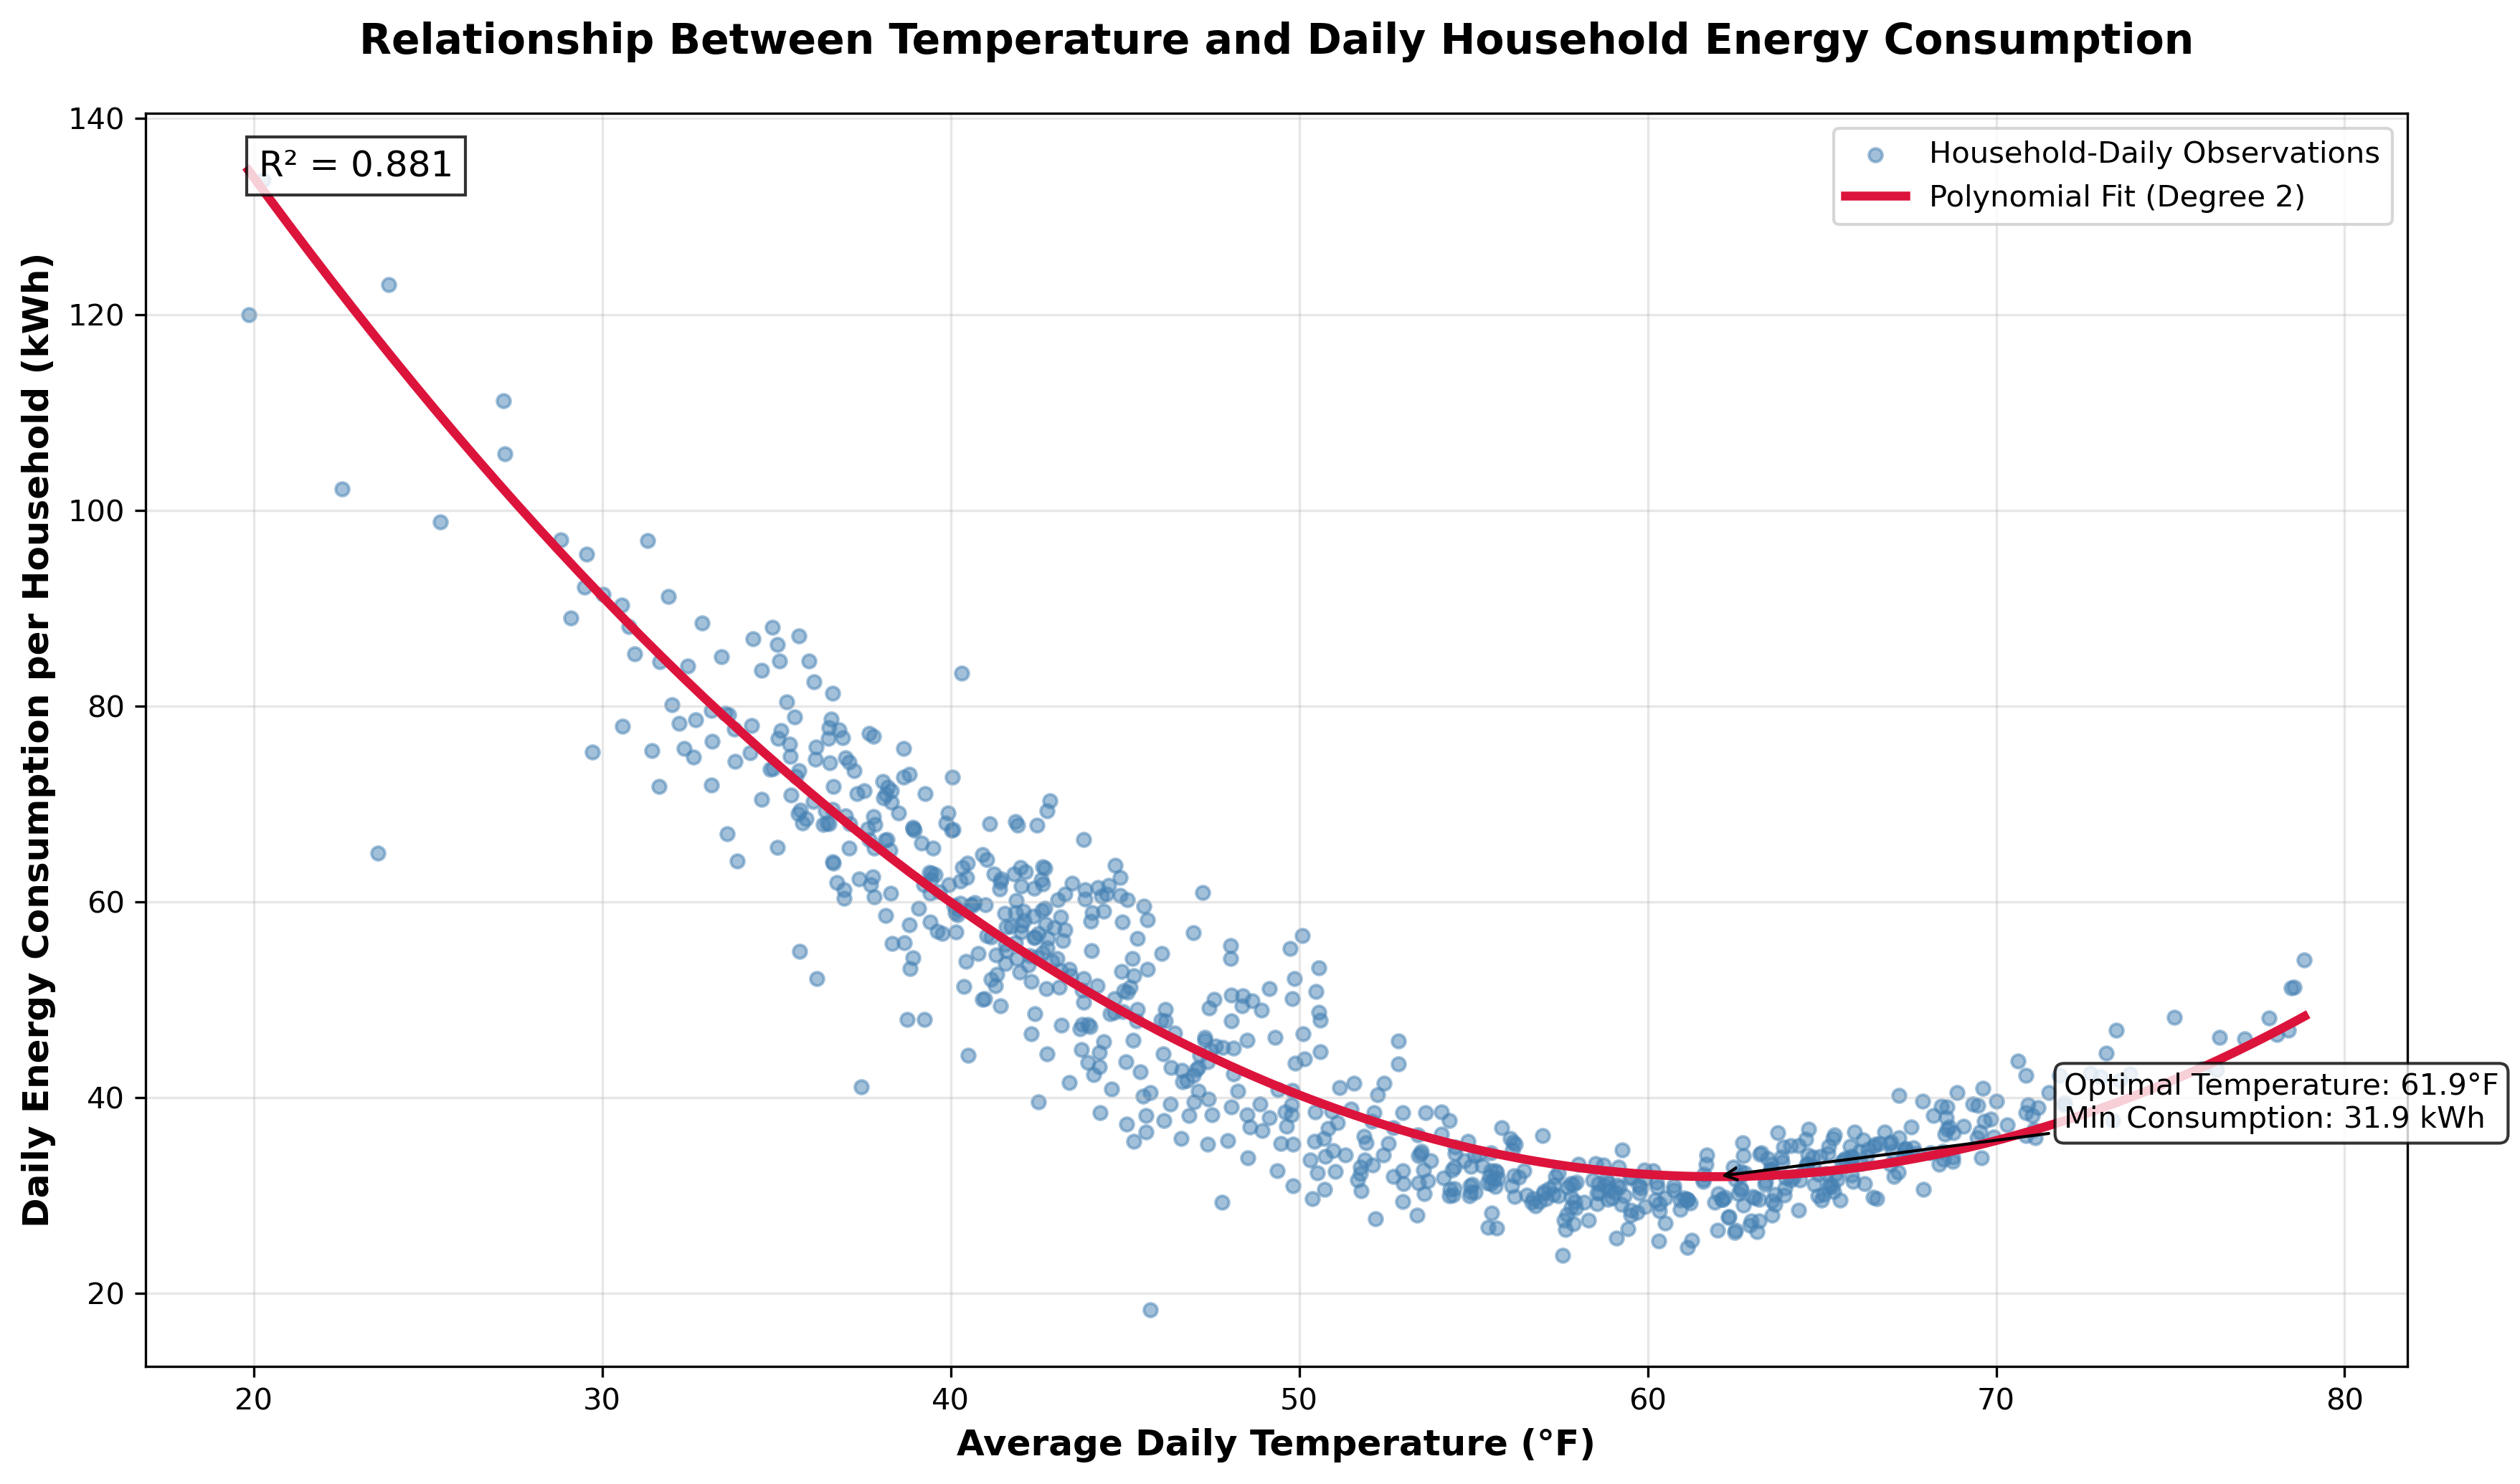

{'r_squared': 0.8813661804499621,
 'optimal_temperature': 61.946805904522556,
 'min_consumption': 31.915838720782574,
 'model_coefficients': [0.0, -7.171991447663875, 0.05782330239158462],
 'model_intercept': 254.30626929262436}

In [14]:
plot_kwh_vs_temp_poly(df)